# Modeling - XGBoost

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
# read in the cleaned flight delay data
flight_delay_df = pd.read_csv('../data/flight_delay_cleaned.csv')
flight_delay_df.head()

,date,delay_severity,avg_wind_speed_lga,precipitation_lga,snowfall_lga,snow_depth_lga,average_temp_lga,max_temp_lga,min_temp_lga,wind_direction_fastest_2min_lga,...,6am-9am _dep,6pm-9pm _dep,9am-12pm _dep,9pm-12am _dep,12pm-3pm _arr,3pm-6pm _arr,6am-9am _arr,6pm-9pm _arr,9am-12pm _arr,9pm-12am _arr
0,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,1,0,0,0
1,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,1,0,0,0
2,2015-01-01,2,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,0,0,1,0
3,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,1,0,0,0,0,0,0,0,1,0
4,2015-01-01,0,13.87,0.0,0.0,0.0,31.0,39.0,27.0,240.0,...,0,0,1,0,0,0,0,0,1,0


In [3]:
# create X and y variables
X = flight_delay_df.drop(columns=['date', 'delay_severity'])
y = flight_delay_df['delay_severity']

In [4]:
# split data with train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=96)

In [5]:
# Instantiate pipeline object with Standard Scaler and XGB Classifier
rs_xgb_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('xgb', XGBClassifier())
])

# Set dictionary of hyperparameters
pipe_params = {
    'xgb__learning_rate'    : [0.01, 0.1, 0.2, 0.3],
    'xgb__n_estimators'     : [100, 150, 200, 500, 1000],
    'xgb__min_child_weight' : [1, 3, 5, 7],
    'xgb__max_depth'        : [3, 5, 8, 11, 14],
    'xgb__subsample'        : [0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree' : [0.7, 0.8, 0.9, 1.0],
    'xgb__gamma'            : [0, 0.1, 0.2],
    'xgb__scale_pos_weight' : [1],
    'xgb__random_state'     : [96],
    'xgb__reg_alpha'        : [0.001, 0.01, 0.05, 0.1, 1],
    'xgb__reg_lambda'        : [1],
}

# Instatiate Randomized Search object (optimize for recall)
rs_xgb = RandomizedSearchCV(estimator = rs_xgb_pipe,
                            param_distributions = pipe_params,
                            n_iter = 120,
                            n_jobs = -2,
                            cv=5,
                            verbose=1)

In [6]:
# Fit the RandomSearch object to the data
rs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/JULIA/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/JULIA/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:51:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                                   

In [7]:
# check the best train and test scores
print(f'Train score: {rs_xgb.score(X_train, y_train)}')
print(f'Test score: {rs_xgb.score(X_test, y_test)}')

Train score: 0.7623587089745336
Test score: 0.7260348583877996


In [8]:
# check the recall score
preds = rs_xgb.predict(X_test)
recall = recall_score(y_test, preds, average='macro')
print(f'Recall score: {recall}')

Recall score: 0.5501999696589848


In [9]:
# view the best hyperparameters
rs_xgb.best_params_

{'xgb__subsample': 0.9,
 'xgb__scale_pos_weight': 1,
 'xgb__reg_lambda': 1,
 'xgb__reg_alpha': 0.001,
 'xgb__random_state': 96,
 'xgb__n_estimators': 500,
 'xgb__min_child_weight': 5,
 'xgb__max_depth': 3,
 'xgb__learning_rate': 0.1,
 'xgb__gamma': 0,
 'xgb__colsample_bytree': 1.0}

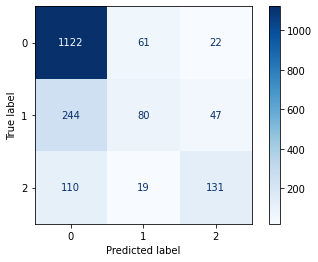

In [10]:
# plot the confusion matrix
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=rs_xgb.classes_).plot(cmap='Blues');